# Roshambo game : offline preliminary analysis

## Load the recorded data 

In [1]:
fname = "./../data/bitalino_emg_A12.hdf5" 

In [2]:
import pandas as pd

df_filtered = pd.read_hdf(fname, "/filtered")
events = pd.read_hdf(fname, "/events")

## Implement the estimator to extract the features 

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array

class EMGFeatures(BaseEstimator, TransformerMixin):
    """EMG Temporal features"""
    def fit(self, X, y=None):
        """"""
        return self

    def transform(self, X):
        """Extract EMG temporal features
        Parameters
        ----------
        X : ndarray, shape (n_trials, n_samples, n_channels)
            Data to extract features from
        Returns
        -------
        features : ndarray, shape (n_trials, n_features)
            Temporal features
        """
        X = check_array(X, allow_nd=True)
        shapeX = X.shape

        if len(shapeX) == 3:
            Nt, Ns, Ne = shapeX
        else:
            raise ValueError("X.shape should be (n_trials, n_samples, n_electrodes).")
        
        features = np.hstack([np.max(X, axis=1), np.std(X, axis=1), np.apply_along_axis(self._zero_crossing_rate, 1, X)])
        return features

    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : ndarray, shape (n_trials,  n_samples, n_channels)
            Data to extract features from
        y : ndarray, shape (n_trials,) | None, optional
            labels corresponding to each trial, not used (mentioned for sklearn comp)
        Returns
        -------
        X : ndarray, shape (n_trials, n_features)
            Temporal features
        """
        self.fit(X, y)
        return self.transform(X)
    
    @staticmethod
    def _zero_crossing_rate(x):
        return len(np.where(np.diff(np.sign(x)))[0]) / len(x)

In [4]:
from timeflux.nodes.epoch import Epoch

epoch = Epoch(before=0.0, after=3.0, event_trigger="trial_starts")
epoch.i.data = df_filtered
epoch.i_events.data = events
epoch.update()

In [5]:
epochs = []
labels = []
for port_name, _, port in epoch.iterate():
    label = port.meta.get("epoch", {}).get("context", {}).get("id")
    if label:
        epochs.append(port.data) 
        labels.append(label)

In [6]:
X = np.stack([epoch.values for epoch in epochs])
features = EMGFeatures().transform(X)
df_features = pd.DataFrame(features, columns=["A1_max", "A2_max", "A1_std", "A2_std", "A1_zcr", "A2_zcr"])
df_features["label"] = labels

## Visualize the features distributions

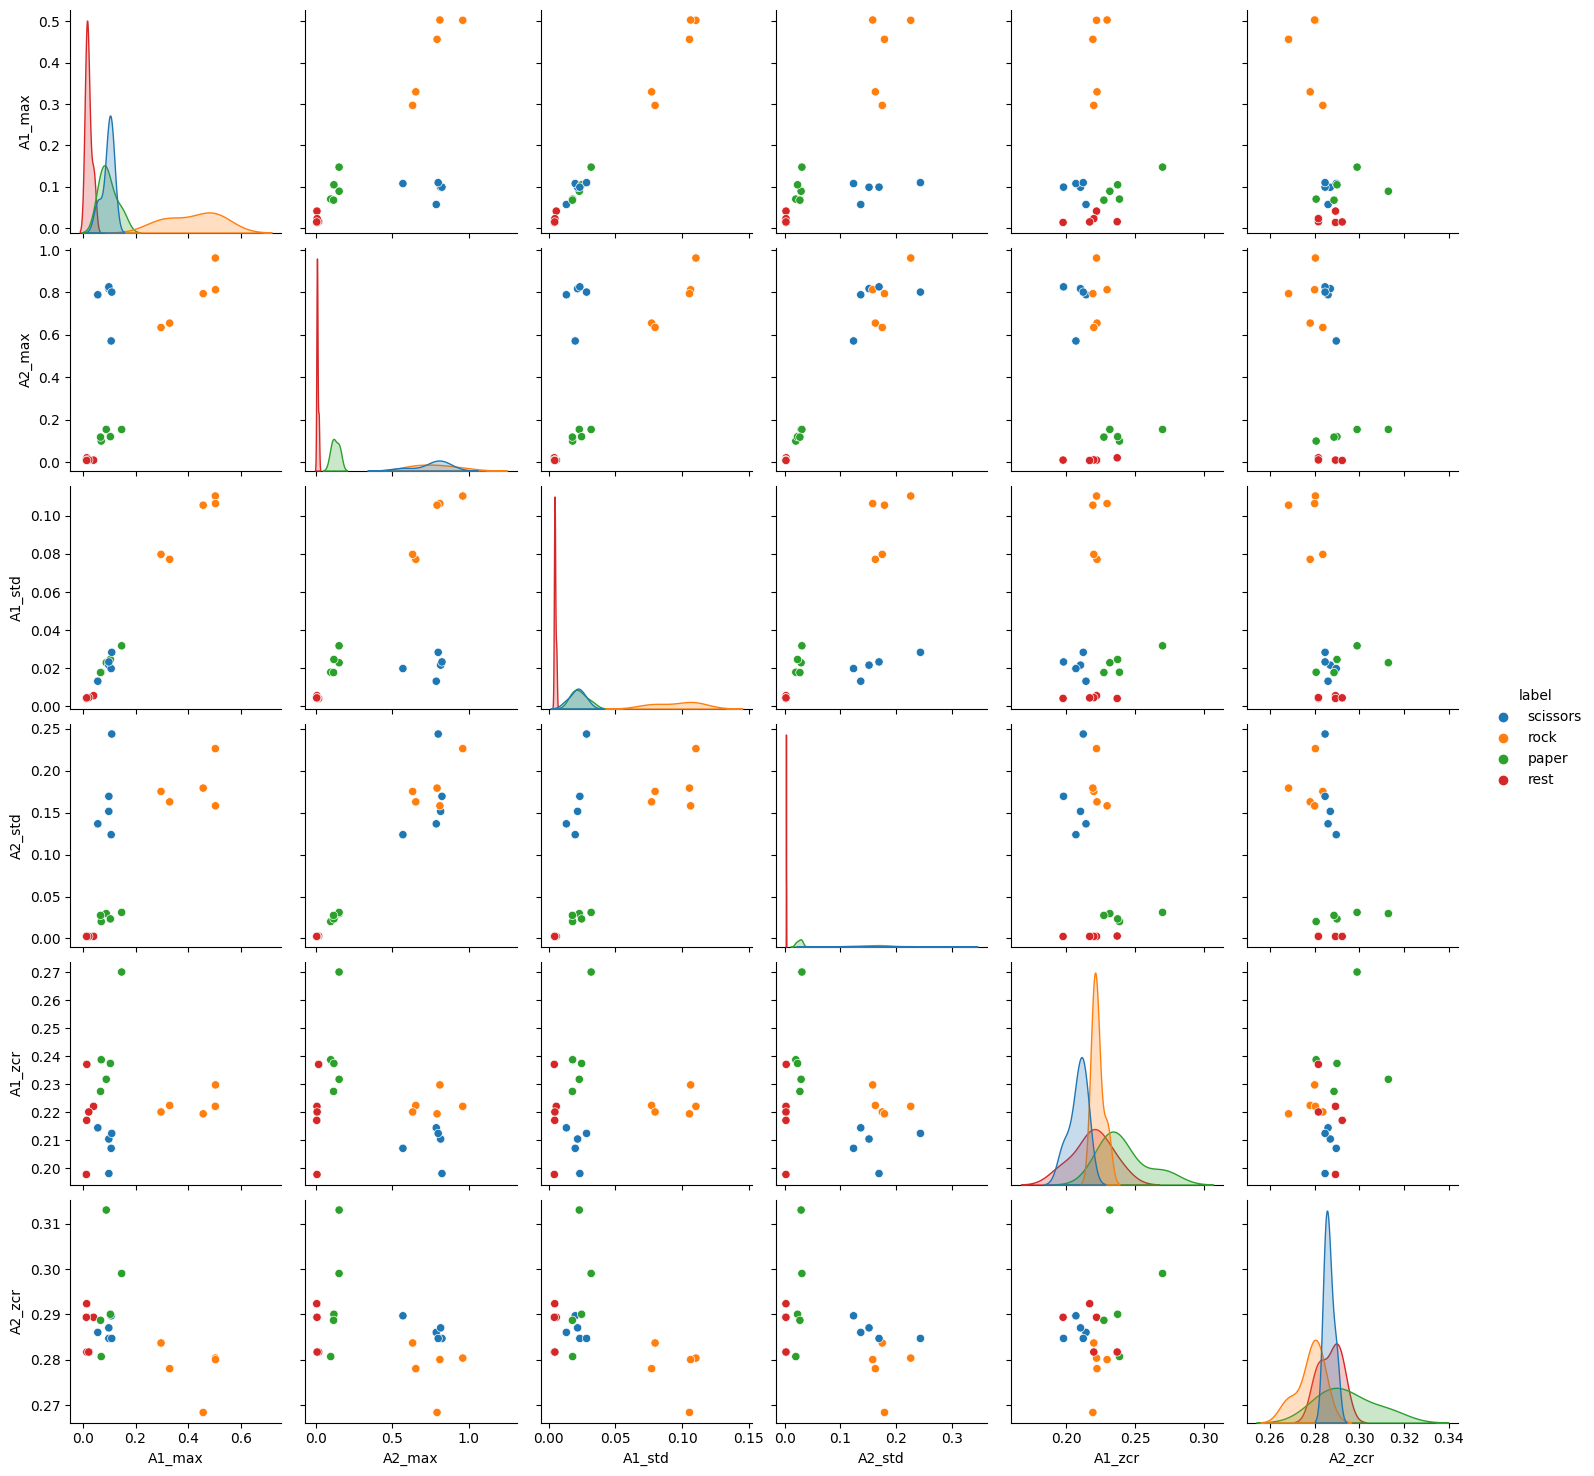

In [7]:
import seaborn as sns
sns.pairplot(df_features, hue='label')  

## See how it classifies the classes 

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline(
  steps=[
    ('features', EMGFeatures()),
    ('norm', Normalizer()),
    ('classifier', KNeighborsClassifier())
  ]
)

In [9]:
label_encoder = {label: code for code, label in enumerate(set(df_features.label))}
y = np.array([label_encoder[label] for label in df_features.label.values])

# fit on first 12, and predict last 8
n_train = 12
pipeline.fit(X[:n_train,:], y[:n_train])
y_pred = pipeline.predict(X[n_train:, :])
y_true = y[n_train:]

/Users/raph/Code/timeflux/demos/venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


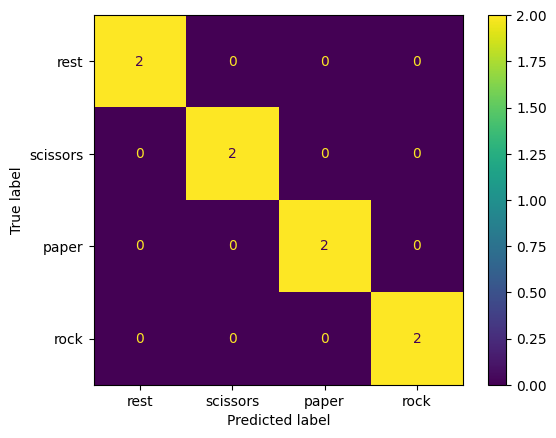

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=list(label_encoder.keys())).plot()